### About the dataset

The dataset contains the following information of 30000 customers:

DEFAULT - Default payment next month (Yes=1, No=0), now has been inverted

LIMIT_BAL - Amount of the given credit (INR)

SEX - Gender (1 = male; 2 = female)

EDUCATION - Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

MARRIAGE - (1 = married; 2 = single; 3 = others)

AGE - (year)

PAY - History of repayment status

- PAY1 = the repayment status in September 2005
- PAY2 = the repayment status in August 2005 ....
- PAY6 = the repayment status in April 2005
- The measurement scale for the repayment status is:

  i. - 1 = pay duly <br>
  ii. 1 = payment delay for one month<br>
  iii. 2 = payment delay for two months <br>
  iv. 8 = payment delay for eight months<br>
  v. 9 = payment delay for nine months and above <br>

BILL_AMT- Amount of bill statement (INR)

- BILL_AMT1 = amount of bill statement in September 2005
- BILL_AMT2 = amount of bill statement in August 2005....
- BILL_AMT6 = amount of bill statement in April 2005

PAY_AMT - Amount of previous payment (INR)

- PAY_AMT1 = amount paid in September 2005
- PAY_AMT2 = amount paid in August 2005....
- PAY_AMT6 = amount paid in April 2005

### Additional information

- The difference between the bill amount and the past pay for a month will give an indication of the pending amount for each month and can be used as an additional X variable

- The average / sum of bill amount can be used as an additional X variable which will give an indication on the customer value.


In [204]:
# NOW WE ARE TRYING TO PREDICT WHETHER A CUSTOMER WOULD MAKE THE PAYMENT IN TIME OR NOT, 

# 1 MEANS THAT THE CUSTOMER MAKES THE PAYMENT ON TIME, 
# 0 MEANS THAT THE CUSTOMER DOESN'T MAKE THE PAYMENT ON TIME


#### Precision:

Proportion of positive predictions that are actually positive.
High precision is important when the cost of false positives (predicting a customer will pay on time when they won't) is high.
For example, if false positives lead to increased risk of default, then precision is crucial.
#### Recall:

Measures the proportion of actual positive cases that are correctly identified.
High recall is important when the cost of false negatives (predicting a customer won't pay on time when they will) is high.
For instance, if false negatives lead to lost revenue or missed opportunities, then recall is crucial.
#### F1-Score:

The harmonic mean of precision and recall.
It provides a balanced measure of both precision and recall.
A high F1-score indicates a good balance between precision and recall.

In [205]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings

warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    ConfusionMatrixDisplay,

)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint as sp_randint
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [206]:
df = pd.read_csv("res/UCI_Credit_Card.csv")
df.rename(
    columns={"PAY_0": "PAY_1", "default.payment.next.month": "def_pay"}, inplace=True
)
df["def_pay"] = df["def_pay"].apply(lambda x: 1 if x == 0 else 0)

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,0
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,0
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,1
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,1
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1


In [207]:
# replacing negative bill amounts with 0, since they don't mean anything
bill_amt_columns = [
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
]

for col in bill_amt_columns:
    df[col] = df[col].apply(lambda x: max(x, 0))

In [208]:
df[df["ID"].duplicated()]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay


In [209]:
df.drop(["ID"], axis=1, inplace=True)
data = df.copy()

In [210]:
df.shape

(30000, 24)

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [212]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


In [213]:
df.isnull().sum().sum()

0

In [214]:
cols = df.columns.to_list()
cols

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'def_pay']

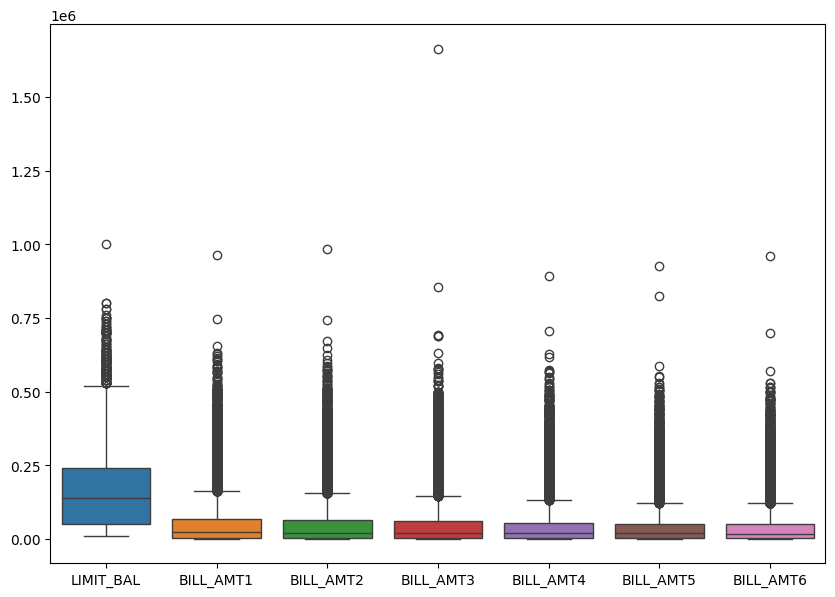

In [215]:
# boxplot for bill_Amt and limit_bal

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=df[
        [
            "LIMIT_BAL",
            "BILL_AMT1",
            "BILL_AMT2",
            "BILL_AMT3",
            "BILL_AMT4",
            "BILL_AMT5",
            "BILL_AMT6",
        ]
    ]
)

plt.show()

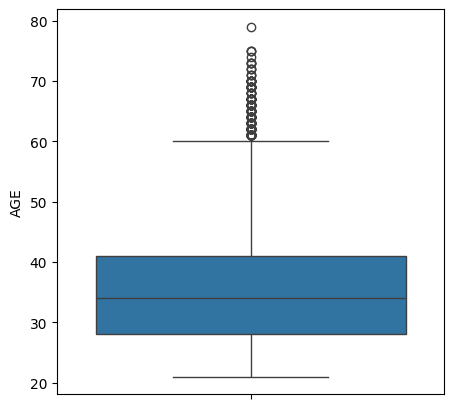

In [216]:
# Boxplot for column 'AGE'
plt.figure(figsize=(5, 5))
sns.boxplot(data=df["AGE"])
plt.show()

In [217]:
# Outliers on numerical Columns
num_var = df.select_dtypes(exclude="object")
for i in num_var:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)

    IQR = q3 - q1
    UL = q3 + 1.5 * IQR
    LL = q1 - 1.5 * IQR

    print("IQR of", i, "= ", IQR)
    print("UL of", i, "= ", UL)
    print("LL of", i, "= ", LL)
    print(
        f"Number of Outliers in {i} = {(df.shape[0] - df[(df[i] < UL) & (df[i] > LL)].shape[0])}"
    )
    print(" ")

IQR of LIMIT_BAL =  190000.0
UL of LIMIT_BAL =  525000.0
LL of LIMIT_BAL =  -235000.0
Number of Outliers in LIMIT_BAL = 167
 
IQR of SEX =  1.0
UL of SEX =  3.5
LL of SEX =  -0.5
Number of Outliers in SEX = 0
 
IQR of EDUCATION =  1.0
UL of EDUCATION =  3.5
LL of EDUCATION =  -0.5
Number of Outliers in EDUCATION = 454
 
IQR of MARRIAGE =  1.0
UL of MARRIAGE =  3.5
LL of MARRIAGE =  -0.5
Number of Outliers in MARRIAGE = 0
 
IQR of AGE =  13.0
UL of AGE =  60.5
LL of AGE =  8.5
Number of Outliers in AGE = 272
 
IQR of PAY_1 =  1.0
UL of PAY_1 =  1.5
LL of PAY_1 =  -2.5
Number of Outliers in PAY_1 = 3130
 
IQR of PAY_2 =  1.0
UL of PAY_2 =  1.5
LL of PAY_2 =  -2.5
Number of Outliers in PAY_2 = 4410
 
IQR of PAY_3 =  1.0
UL of PAY_3 =  1.5
LL of PAY_3 =  -2.5
Number of Outliers in PAY_3 = 4209
 
IQR of PAY_4 =  1.0
UL of PAY_4 =  1.5
LL of PAY_4 =  -2.5
Number of Outliers in PAY_4 = 3508
 
IQR of PAY_5 =  1.0
UL of PAY_5 =  1.5
LL of PAY_5 =  -2.5
Number of Outliers in PAY_5 = 2968
 
IQR o

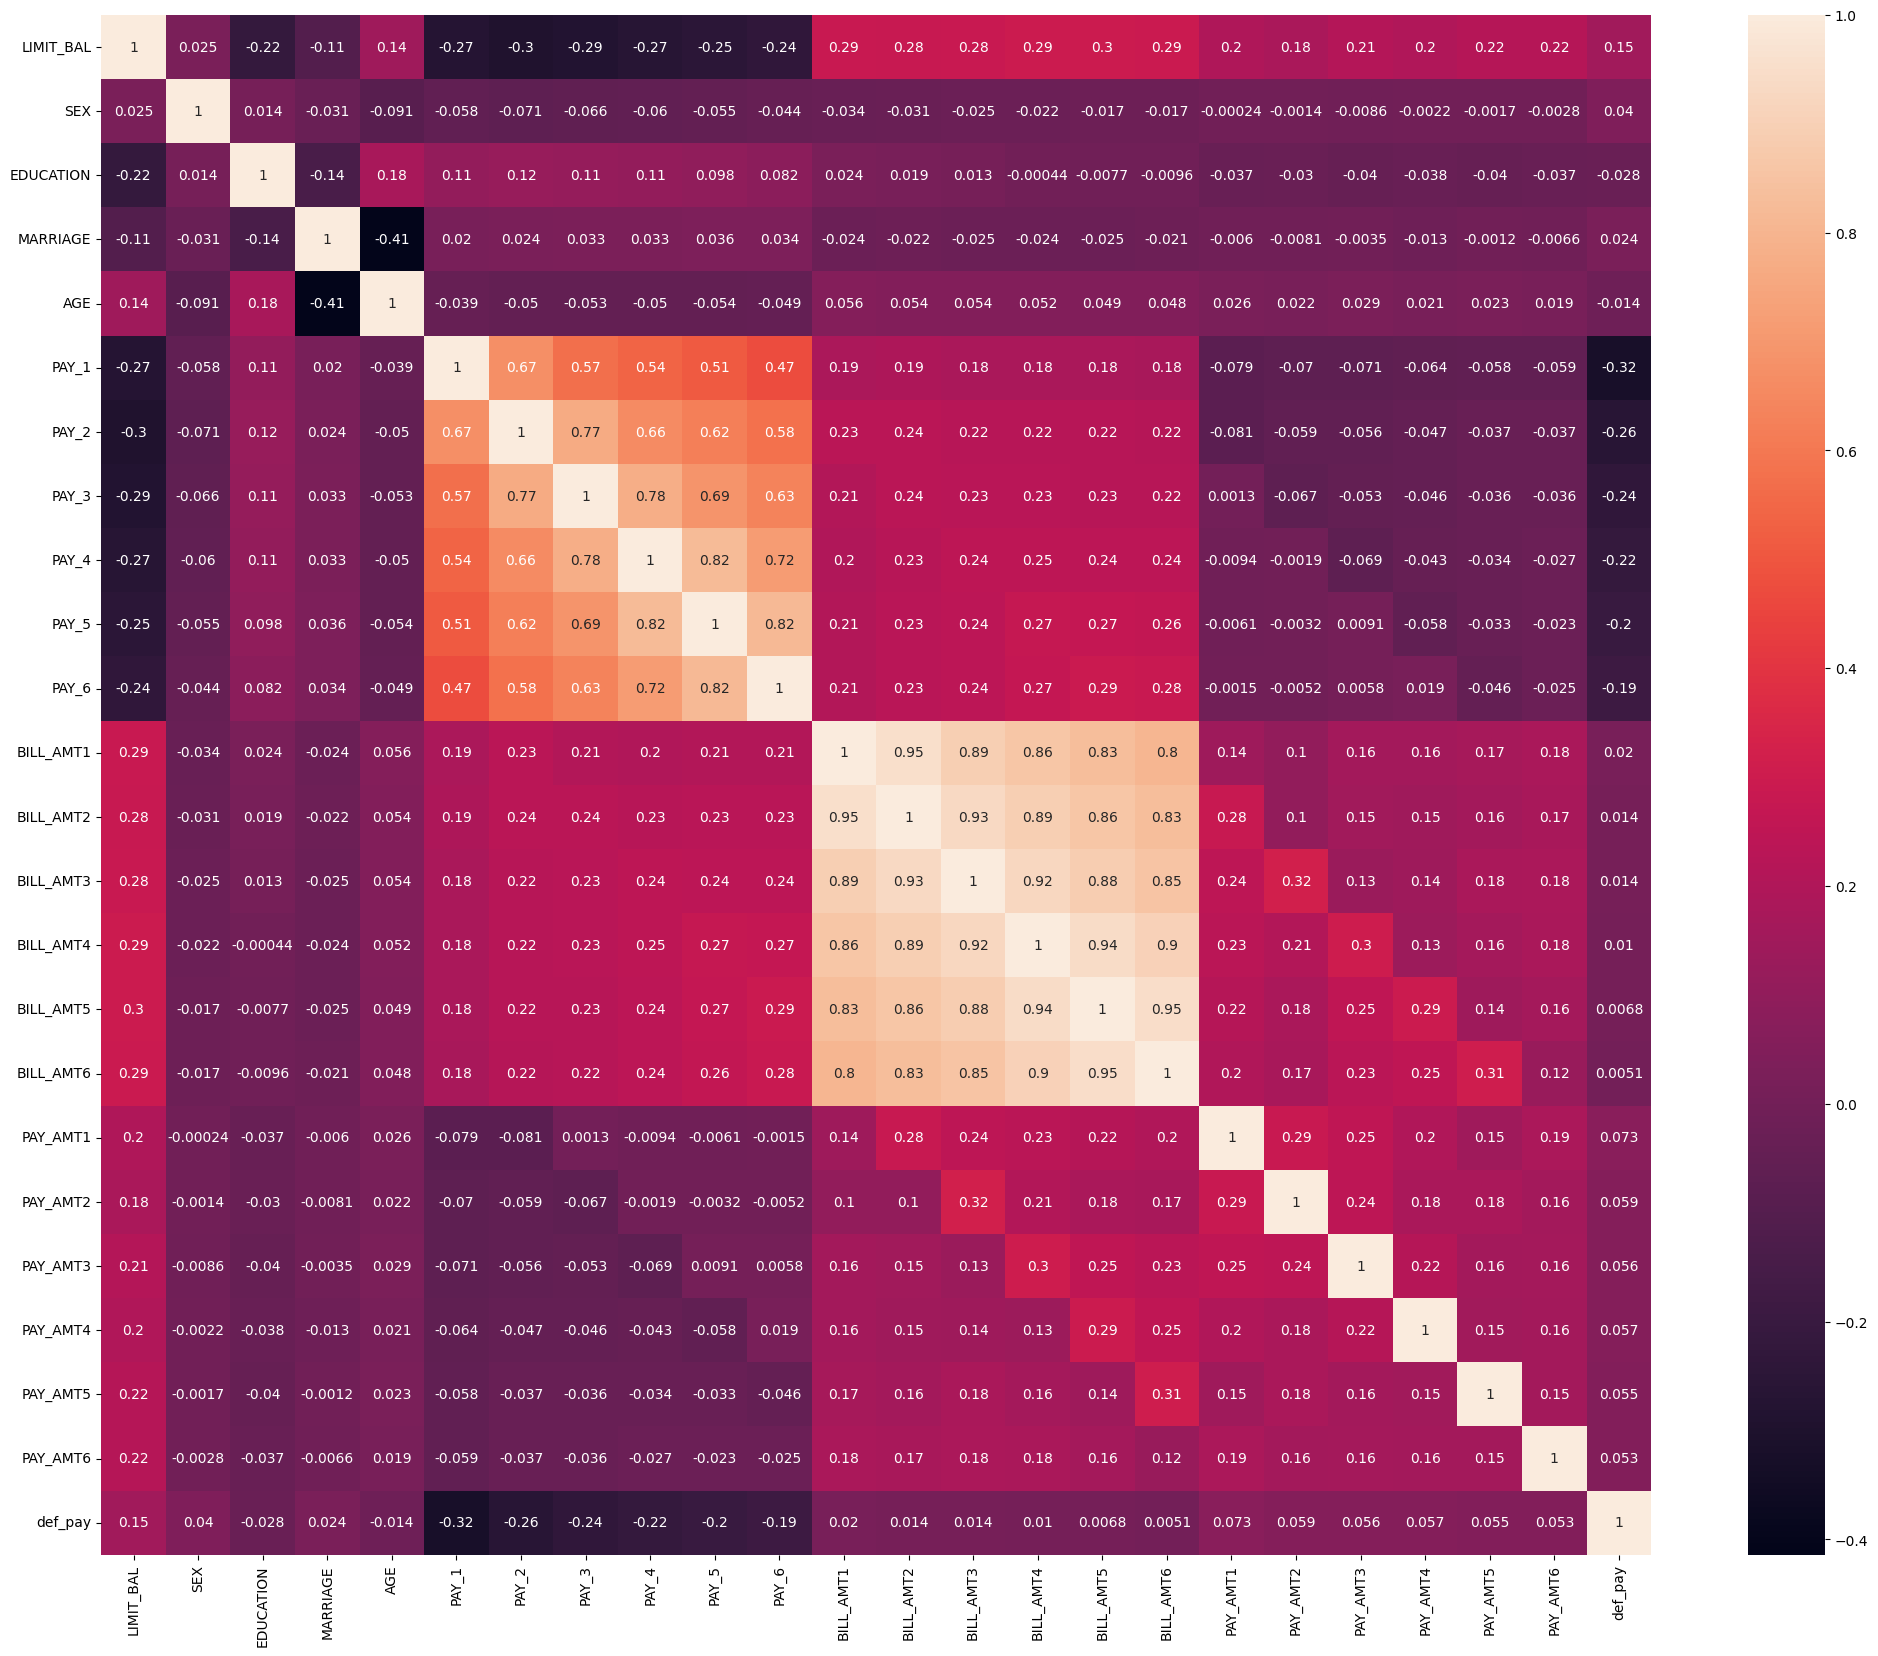

In [218]:
# Checking correlation
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [219]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,0
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,0
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,1
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,1
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1


def_pay
1    77.88
0    22.12
Name: count, dtype: float64


<Axes: xlabel='def_pay', ylabel='Count'>

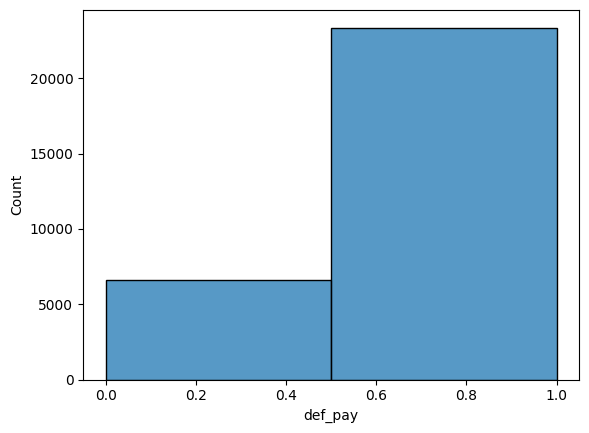

In [220]:
print(
    (
        df["def_pay"].value_counts()
        / df["def_pay"].shape
    )
    * 100
)
# sns.countplot(df['def_pay'])
sns.histplot(df["def_pay"], bins=2)
# plt.show()

In [221]:
# Acc to the data, 77% of the customers pay on time, 22% tend to be defaulters and NOT pay their bills

In [222]:
# BaseLine modeling

# Splitting
X_base = df.drop("def_pay", axis=1)
y_base = df["def_pay"]

# Train_test_split
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base, y_base, test_size=0.3, random_state=2
)

# defining a Logistic regression baseline model
logreg_base = LogisticRegression(solver="liblinear", fit_intercept=True)
logreg_base.fit(X_train_base, y_train_base)

y_pred_base = logreg_base.predict(X_test_base)
print(
    "Classification report - Test: ",
    "\n",
    classification_report(y_test_base, y_pred_base),
)

Classification report - Test:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1994
           1       0.78      1.00      0.88      7006

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.68      9000



### Inferences:

- Model is completely biased towards class 0, and fails to predict class 1 at all... but a good baseline to improve upon


In [223]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_tmp = df.drop(["def_pay"], axis=1)
vif = pd.DataFrame()

vif["Features"] = df_tmp.columns
vif["vif"] = [variance_inflation_factor(df_tmp.values, i) for i in range(df_tmp.shape[1])]

vif

,Features,vif
0,LIMIT_BAL,4.037258
1,SEX,9.092001
2,EDUCATION,6.731239
3,MARRIAGE,6.265319
4,AGE,10.857814
5,PAY_1,1.918419
6,PAY_2,3.210988
7,PAY_3,3.727119
8,PAY_4,4.439915
9,PAY_5,4.986271


In [224]:
# Calculate the ratio of PAY_AMT to BILL_AMT for each month
# pay_bill_ratio1 = (data["PAY_AMT1"]) / (data["BILL_AMT1"] + 1e-4)
# pay_bill_ratio2 = (data["PAY_AMT2"]) / (data["BILL_AMT2"] + 1e-4)
# pay_bill_ratio3 = (data["PAY_AMT3"]) / (data["BILL_AMT3"] + 1e-4)
# pay_bill_ratio4 = (data["PAY_AMT4"]) / (data["BILL_AMT4"] + 1e-4)
# pay_bill_ratio5 = (data["PAY_AMT5"]) / (data["BILL_AMT5"] + 1e-4)
# pay_bill_ratio6 = (data["PAY_AMT6"]) / (data["BILL_AMT6"] + 1e-4)

# Calculate the ratio (BILL_AMT - PAY_AMT) / LIMIT_BALANCE for each month
pay_bill_ratio1 = (data["BILL_AMT1"] - data["PAY_AMT1"]) / (data["LIMIT_BAL"] + 1e-4)
pay_bill_ratio2 = (data["BILL_AMT2"] - data["PAY_AMT2"]) / (data["LIMIT_BAL"] + 1e-4)
pay_bill_ratio3 = (data["BILL_AMT3"] - data["PAY_AMT3"]) / (data["LIMIT_BAL"] + 1e-4)
pay_bill_ratio4 = (data["BILL_AMT4"] - data["PAY_AMT4"]) / (data["LIMIT_BAL"] + 1e-4)
pay_bill_ratio5 = (data["BILL_AMT5"] - data["PAY_AMT5"]) / (data["LIMIT_BAL"] + 1e-4)
pay_bill_ratio6 = (data["BILL_AMT6"] - data["PAY_AMT6"]) / (data["LIMIT_BAL"] + 1e-4)


# Add the ratio as new columns to the dataframe
data[
    [
        "PAY_BILL_RATIO1",
        "PAY_BILL_RATIO2",
        "PAY_BILL_RATIO3",
        "PAY_BILL_RATIO4",
        "PAY_BILL_RATIO5",
        "PAY_BILL_RATIO6",
    ]
] = pd.DataFrame(
    {
        "PAY_BILL_RATIO1": pay_bill_ratio1,
        "PAY_BILL_RATIO2": pay_bill_ratio2,
        "PAY_BILL_RATIO3": pay_bill_ratio3,
        "PAY_BILL_RATIO4": pay_bill_ratio4,
        "PAY_BILL_RATIO5": pay_bill_ratio5,
        "PAY_BILL_RATIO6": pay_bill_ratio6,
    }
)


# Drop the original columns related to bills and payments
df = data.drop(
    [
        "BILL_AMT1",
        "BILL_AMT2",
        "BILL_AMT3",
        "BILL_AMT4",
        "BILL_AMT5",
        "BILL_AMT6",
        "PAY_AMT1",
        "PAY_AMT2",
        "PAY_AMT3",
        "PAY_AMT4",
        "PAY_AMT5",
        "PAY_AMT6",
    ],
    axis=1,
)

# Show the first few rows to confirm
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,PAY_BILL_RATIO3,PAY_BILL_RATIO4,PAY_BILL_RATIO5,PAY_BILL_RATIO6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,0,0.195650,0.120650,0.034450,0.000000,0.000000,0.000000
1,120000.0,2,2,2,26,-1,2,0,0,0,2,0,0.022350,0.006042,0.014017,0.018933,0.028792,0.010508
2,90000.0,2,2,2,34,0,0,0,0,0,0,1,0.308011,0.139189,0.139544,0.148122,0.154978,0.117211
3,50000.0,2,2,1,37,0,0,0,0,0,0,1,0.899800,0.924280,0.961820,0.544280,0.557800,0.570940
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,1,0.132340,-0.620220,0.516700,0.238800,0.369140,0.369040


## Now doing some feature engineering


In [225]:
# Creating a defaulter column, coz those who defaulted in past, have more of a tendency to do so in the future
df["defaulting_frequency"] = (
    df[["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]] > 0
).sum(axis=1)

In [226]:
def bin_pays(x):
    """Binning the 'PAY' Columns"""
    if x <= 0:
        return "Paid Duly"
    elif x in range(1, 4):
        return "1 to 3"
    elif x in range(4, 7):
        return "4 to 6"
    elif x in range(7, 9):
        return "7 to 9"


def fix_education(x):
    if x in [0, 4, 5, 6]:
        return 4
    else:
        return x

# Define bins and labels
bins = [20, 27, 32, 37, 42, 48, 58, 64, 80]
labels = [8, 7, 6, 5, 4, 3, 2, 1]

# Bin the AGE column
df["AGE_GROUP"] = pd.cut(df["AGE"], bins=bins, labels=labels)

df["EDUCATION"] = df["EDUCATION"].apply(fix_education)

for i in df[["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]]:
    df[i] = df[i].apply(bin_pays)

print(f"Dataset after Feature Engineering: \n")
df.head()

Dataset after Feature Engineering: 



,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,PAY_BILL_RATIO3,PAY_BILL_RATIO4,PAY_BILL_RATIO5,PAY_BILL_RATIO6,defaulting_frequency,AGE_GROUP
0,20000.0,2,2,1,24,1 to 3,1 to 3,Paid Duly,Paid Duly,Paid Duly,Paid Duly,0,0.195650,0.120650,0.034450,0.000000,0.000000,0.000000,2,8
1,120000.0,2,2,2,26,Paid Duly,1 to 3,Paid Duly,Paid Duly,Paid Duly,1 to 3,0,0.022350,0.006042,0.014017,0.018933,0.028792,0.010508,2,8
2,90000.0,2,2,2,34,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,1,0.308011,0.139189,0.139544,0.148122,0.154978,0.117211,0,6
3,50000.0,2,2,1,37,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,1,0.899800,0.924280,0.961820,0.544280,0.557800,0.570940,0,6
4,50000.0,1,2,1,57,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,1,0.132340,-0.620220,0.516700,0.238800,0.369140,0.369040,0,3


In [227]:
df.drop(["AGE"], axis=1, inplace=True)
df.rename(columns={'AGE_GROUP':'AGE'}, inplace=True)

In [228]:
# Encoding Categorical Variables
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in df.select_dtypes(include=object).columns:
    df[col] = le.fit_transform(df[col])

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,PAY_BILL_RATIO3,PAY_BILL_RATIO4,PAY_BILL_RATIO5,PAY_BILL_RATIO6,defaulting_frequency,AGE
0,20000.0,2,2,1,0,0,3,3,3,3,0,0.195650,0.120650,0.034450,0.000000,0.000000,0.000000,2,8
1,120000.0,2,2,2,3,0,3,3,3,0,0,0.022350,0.006042,0.014017,0.018933,0.028792,0.010508,2,8
2,90000.0,2,2,2,3,3,3,3,3,3,1,0.308011,0.139189,0.139544,0.148122,0.154978,0.117211,0,6
3,50000.0,2,2,1,3,3,3,3,3,3,1,0.899800,0.924280,0.961820,0.544280,0.557800,0.570940,0,6
4,50000.0,1,2,1,3,3,3,3,3,3,1,0.132340,-0.620220,0.516700,0.238800,0.369140,0.369040,0,3


In [229]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select the PAY_AMT columns
Customer_demographics = ['AGE', 'EDUCATION', 'MARRIAGE', 'SEX']

# Standardize the data (important for PCA)
scaler = StandardScaler()
pay_scaled = scaler.fit_transform(df[Customer_demographics])

# Apply PCA
pca = PCA(n_components=1)  # Reduce to 2 principal components
demographic_pca = pca.fit_transform(pay_scaled)

# Add the PCA result as a new column
df['Customer_demographics'] = demographic_pca

# Optionally, drop the original PAY_AMT columns
df = df.drop(columns=Customer_demographics)

# Show the updated dataframe with the new PCA feature
df.head()


,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,PAY_BILL_RATIO3,PAY_BILL_RATIO4,PAY_BILL_RATIO5,PAY_BILL_RATIO6,defaulting_frequency,Customer_demographics
0,20000.0,0,0,3,3,3,3,0,0.195650,0.120650,0.034450,0.000000,0.000000,0.000000,2,-0.095390
1,120000.0,3,0,3,3,3,0,0,0.022350,0.006042,0.014017,0.018933,0.028792,0.010508,2,-1.310289
2,90000.0,3,3,3,3,3,3,1,0.308011,0.139189,0.139544,0.148122,0.154978,0.117211,0,-0.525195
3,50000.0,3,3,3,3,3,3,1,0.899800,0.924280,0.961820,0.544280,0.557800,0.570940,0,0.689704
4,50000.0,3,3,3,3,3,3,1,0.132340,-0.620220,0.516700,0.238800,0.369140,0.369040,0,1.990130


In [230]:
# Splitting into dependant and independant variables
X = df.drop("def_pay", axis=1)
y = df["def_pay"]

In [231]:
X.isna().sum()

LIMIT_BAL                0
PAY_1                    0
PAY_2                    0
PAY_3                    0
PAY_4                    0
PAY_5                    0
PAY_6                    0
PAY_BILL_RATIO1          0
PAY_BILL_RATIO2          0
PAY_BILL_RATIO3          0
PAY_BILL_RATIO4          0
PAY_BILL_RATIO5          0
PAY_BILL_RATIO6          0
defaulting_frequency     0
Customer_demographics    0
dtype: int64

In [232]:
from sklearn.preprocessing import StandardScaler

X = df.drop(["def_pay"], axis=1)
y = df["def_pay"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1
)
sc = StandardScaler()
X_train_sc = X_train
X_test_sc = X_test
X_train_sc = sc.fit_transform(X_train_sc)
X_test_sc = sc.transform(X_test_sc)

In [233]:
X_train_sc

array([[-1.13724   , -1.8518493 , -2.41689224, ...,  1.91003118,
         0.7455019 , -0.74301307],
       [-0.90537456,  0.54338567,  0.41775633, ..., -0.80884952,
        -0.53878519,  0.23905839],
       [ 0.0993757 , -1.8518493 ,  0.41775633, ..., -0.80884952,
         0.10335836,  0.21579768],
       ...,
       [-0.90537456,  0.54338567,  0.41775633, ...,  0.27247184,
        -0.53878519, -0.96107679],
       [-0.67350911,  0.54338567,  0.41775633, ..., -0.18275668,
        -0.53878519, -0.76627378],
       [ 1.02683748,  0.54338567,  0.41775633, ..., -0.59293967,
        -0.53878519,  0.65563049]])

In [234]:
def res(y_test_valid, y_train_valid):
    cm_log = confusion_matrix(y_test, y_test_valid)
    ConfusionMatrixDisplay(cm_log).plot()
    
    print(f"f1_score = {f1_score(y_test, y_test_valid)}")
    
    print(classification_report(y_test, y_test_valid))
    
    print("train_accuracy:", accuracy_score(y_train, y_train_valid))
    print("test_accuracy:", accuracy_score(y_test, y_test_valid))

f1_score = 0.8492159227985526
              precision    recall  f1-score   support

           0       0.49      0.56      0.52      1337
           1       0.87      0.83      0.85      4663

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.78      0.77      0.78      6000

train_accuracy: 0.7705416666666667
test_accuracy: 0.7708333333333334


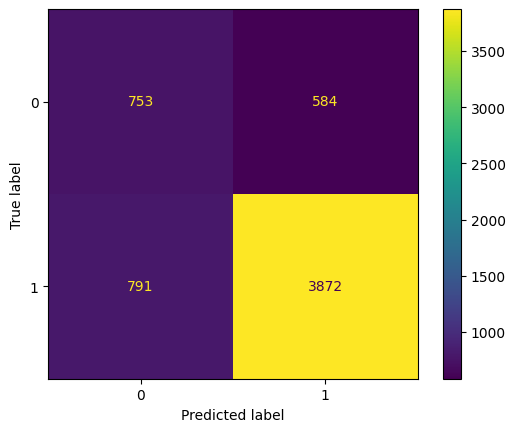

In [235]:
log_model = LogisticRegression(class_weight='balanced')
log_model.fit(X_train_sc, y_train)
y_pred_log = log_model.predict(X_test_sc)
y_pred_train = log_model.predict(X_train_sc)
res(y_pred_log, y_pred_train)

f1_score = 0.8310161636713009
              precision    recall  f1-score   support

           0       0.46      0.62      0.53      1337
           1       0.88      0.79      0.83      4663

    accuracy                           0.75      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.78      0.75      0.76      6000

train_accuracy: 0.751625
test_accuracy: 0.7508333333333334


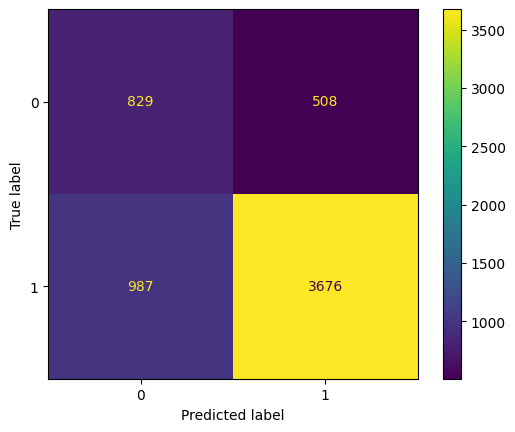

In [236]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3, class_weight='balanced'
)
rf_model.fit(X_train_sc, y_train)
y_pred_rf = rf_model.predict(X_test_sc)
y_pred_rf_train = rf_model.predict(X_train_sc)
res(y_pred_rf, y_pred_rf_train)


LIMIT_BAL: 0.0267
PAY_1: 0.1996
PAY_2: 0.1638
PAY_3: 0.0720
PAY_4: 0.0628
PAY_5: 0.0460
PAY_6: 0.0222
PAY_BILL_RATIO1: 0.0297
PAY_BILL_RATIO2: 0.0248
PAY_BILL_RATIO3: 0.0217
PAY_BILL_RATIO4: 0.0279
PAY_BILL_RATIO5: 0.0152
PAY_BILL_RATIO6: 0.0114
defaulting_frequency: 0.2724
Customer_demographics: 0.0036


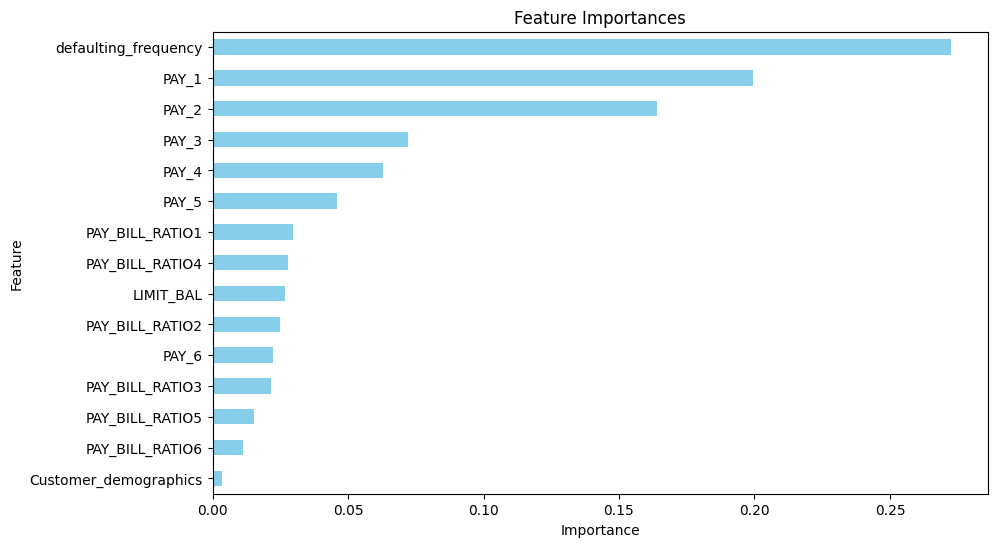

In [237]:
importances = rf_model.feature_importances_

# Loop through feature names and their corresponding importance values
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Remove the ID
# Create a DataFrame for easy plotting
importances_df = pd.Series(importances, index=X_train.columns)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importances_df.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [241]:
corr_matrix = df.corr()

# Create a mask to find pairs with a high correlation (e.g., > 0.9)

# TODO: Correlation higher values: [0.75, 0.8]
mask = (corr_matrix > 0.78) & (corr_matrix < 1.0)

# Get pairs of correlated features
highly_correlated_pairs = corr_matrix[mask]
# Drop one of each pair (for simplicity, we'll drop the second feature in each pair)
features_to_drop = []


for feature in highly_correlated_pairs.columns:
    correlated_features = highly_correlated_pairs[feature].dropna().index.tolist()
    features_to_drop.extend(correlated_features[1:])

df_filtered = df.drop(columns=features_to_drop)
print(f"Dropping: {features_to_drop}")

highly_correlated_pairs

Dropping: ['PAY_BILL_RATIO3', 'PAY_BILL_RATIO4', 'PAY_BILL_RATIO5', 'PAY_BILL_RATIO6']


,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,PAY_BILL_RATIO3,PAY_BILL_RATIO4,PAY_BILL_RATIO5,PAY_BILL_RATIO6,defaulting_frequency,Customer_demographics
LIMIT_BAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
def_pay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_BILL_RATIO1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.828215,0.781320,NaN,NaN,NaN,NaN,NaN
PAY_BILL_RATIO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.828215,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
df_filtered.head()

,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,defaulting_frequency,Customer_demographics
0,20000.0,0,0,3,3,3,3,0,0.195650,0.120650,2,-0.095390
1,120000.0,3,0,3,3,3,0,0,0.022350,0.006042,2,-1.310289
2,90000.0,3,3,3,3,3,3,1,0.308011,0.139189,0,-0.525195
3,50000.0,3,3,3,3,3,3,1,0.899800,0.924280,0,0.689704
4,50000.0,3,3,3,3,3,3,1,0.132340,-0.620220,0,1.990130


In [243]:
# Splitting into dependant and independant variables
X = df_filtered.drop("def_pay", axis=1)
y = df_filtered["def_pay"]

In [244]:
# Identify important features
important_features = [
    feature for feature, importance in zip(X.columns, importances) if importance > 0.02
]

X_transformed_df = X

In [245]:
important_features

['LIMIT_BAL',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'PAY_BILL_RATIO1',
 'PAY_BILL_RATIO2',
 'defaulting_frequency',
 'Customer_demographics']

f1_score = 0.8871032543190036
              precision    recall  f1-score   support

           0       0.65      0.34      0.45      1337
           1       0.83      0.95      0.89      4663

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

train_accuracy: 0.815125
test_accuracy: 0.8126666666666666


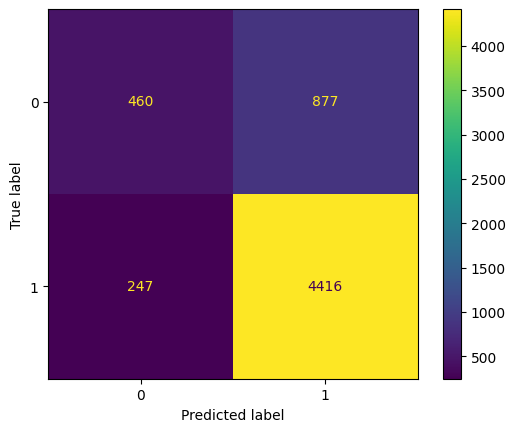

In [246]:
# Training random forest only on the important features
# NOTE: There is no sampling done on the data yet. The data is still organic

X_train, X_test, y_train, y_test = train_test_split(
    X[important_features], y, test_size=0.20, random_state=1
)
sc = StandardScaler()
X_train_sc = X_train
X_test_sc = X_test

X_train_sc = sc.fit_transform(X_train_sc)
X_test_sc = sc.transform(X_test_sc)

rf_model = RandomForestClassifier(
    n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3
)
rf_model.fit(X_train_sc, y_train)
y_pred_rf = rf_model.predict(X_test_sc)
y_pred_rf_train = rf_model.predict(X_train_sc)

res(y_pred_rf, y_pred_rf_train)


LIMIT_BAL: 0.0237
PAY_1: 0.2520
PAY_2: 0.1927
PAY_3: 0.0835
PAY_4: 0.0653
PAY_5: 0.0301
PAY_6: 0.0352
PAY_BILL_RATIO1: 0.0524
PAY_BILL_RATIO2: 0.0389
defaulting_frequency: 0.2181
Customer_demographics: 0.0080


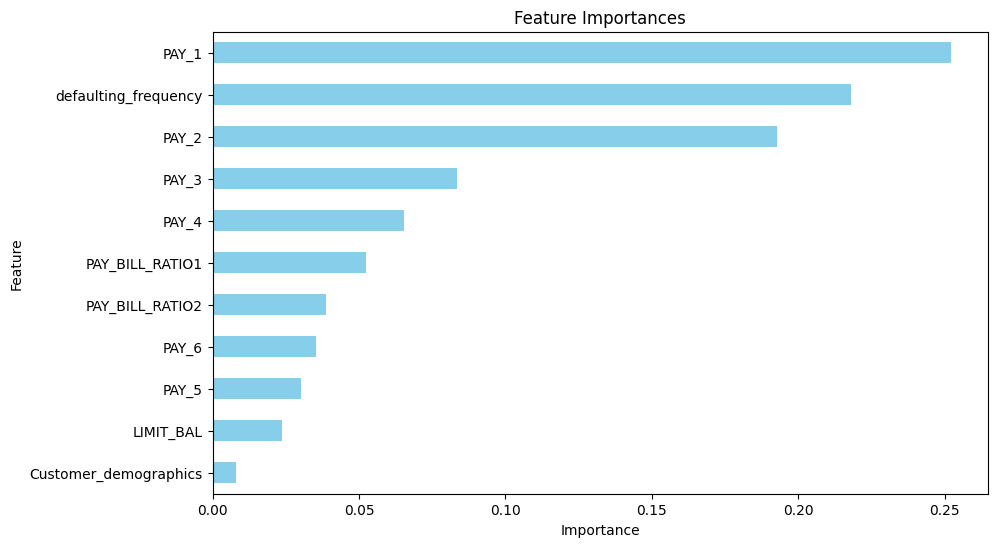

In [247]:
importances = rf_model.feature_importances_

# Loop through feature names and their corresponding importance values
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance:.4f}")

important_features = [
    feature
    for feature, importance in zip(X_train.columns, importances)
    if importance > 0.025
]

# Create a DataFrame for easy plotting
importances_df = pd.Series(importances, index=X_train.columns)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importances_df.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [248]:
important_features

['PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'PAY_BILL_RATIO1',
 'PAY_BILL_RATIO2',
 'defaulting_frequency']

Previous shapes: (24000, 9), (24000,)
Resampled Shape: (29918, 9), (29918,)
def_pay
1    62.500836
0    37.499164
Name: count, dtype: float64


<Axes: xlabel='def_pay', ylabel='Count'>

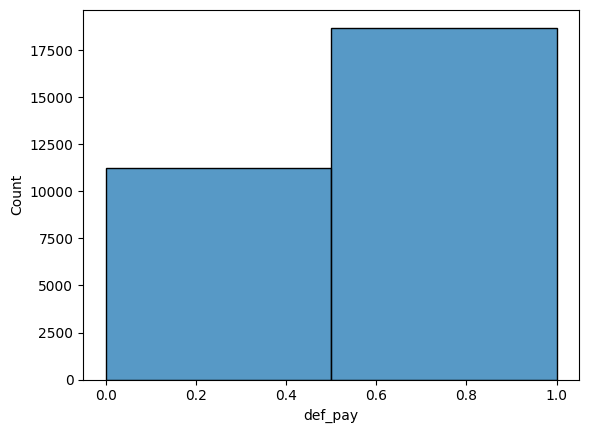

In [249]:
# FURTHER REFINING THE DATASET BASED ON THE FEATURE IMPORTANCES (REDUCED DIMENSIONALITY AND COLUMNS)
# OBJECTIVE HERE IS TO SEE IF UPSAMPLING THE DATA WOULD BE BENEFICIAL FOR THE END RESULT OR NOT 
# (This test is necessary since the data has a very high variance, which may introduce noise upon upsampling)

# Creating global x_test
X_train_glob, X_test, y_train_glob, y_test = train_test_split(
    X_transformed_df[important_features], y, test_size=0.2, random_state=2
)

# Now handle imbalance in data using SMOTE only for the important features
# SMOTEEN
smote = SMOTE(sampling_strategy=0.6, random_state=2)
# smote with tomek links

X_train_glob = sc.fit_transform(X_train_glob)
X_test = sc.fit_transform(X_test)

X_resampled, y_resampled = smote.fit_resample(X_train_glob, y_train_glob)

# New shape:
print(f"Previous shapes: {X_train_glob.shape}, {y_train_glob.shape}")
print(f"Resampled Shape: {X_resampled.shape}, {y_resampled.shape}")

print((y_resampled.value_counts() / y_resampled.shape) * 100)
sns.histplot(y_resampled, bins=2)

In [250]:
from collections import Counter

class_counts = Counter(y_train)  # Example: {0: 9500, 1: 500}
total_samples = len(y_train)
num_classes = len(class_counts)
class_weights1 = {
    cls: total_samples / (num_classes * count) for cls, count in class_counts.items()
}
class_weights1

{0: 2.2645782223060955, 1: 0.6416769156729587}

In [ ]:
# Now doing a final training with multiple models to see which model performs the best. 
# The validation and training data have been created from the above global X_train and y_train.
# The models hyperparameters to be decided on f1 (we need the maximum f1 score here)
# Best model weights would be tested on the non-sampled x_test variable defined before.

In [251]:
from lightgbm import LGBMClassifier as lgb
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.utils import class_weight


results = {}

# Splitting dataset into training and validation sets (modify as per your dataset)
# Assuming X_resampled and y_resampled are your features and target labels after balancing
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=2
)

class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)


scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # for XGB

# Define models to test
models = {
    "LightGBM": lgb(verbose=-1, n_jobs=-1, is_unbalance=True),
    "Logistic Regression": LogisticRegression(class_weight=class_weights1, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_jobs=-1, class_weight=class_weights1),
    "Gradient Boosting": GradientBoostingClassifier(),  # No explicit `n_jobs`
    "XGBoost": XGBClassifier(n_jobs=-1, scale_pos_weight=scale_pos_weight),
}

# Define parameter distributions
param_distributions = {
    "Random Forest": {
        "n_estimators": randint(100, 500),
        "max_depth": [None, 10, 20],
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 20),
        "bootstrap": [True, False],
    },
    "Logistic Regression": {
        "C": uniform(0.01, 100),
        "penalty": ["l2"],
        "solver": ["lbfgs", "liblinear"],
        "max_iter": [100, 200],
    },
    "Gradient Boosting": {
        "n_estimators": randint(100, 500),
        "learning_rate": uniform(0.01, 0.5),
        "max_depth": randint(3, 7),
        "subsample": uniform(0.5, 0.5),  # Ensures values between 0.5 and 1.0
        "min_samples_split": randint(2, 10),
    },
    "XGBoost": {  # Add XGBoost parameters
        "n_estimators": randint(100, 500),
        "learning_rate": uniform(0.01, 0.3),
        "max_depth": randint(3, 7),
        "subsample": uniform(0.5, 0.5),  # Ensures values between 0.5 and 1.0
        "colsample_bytree": uniform(0.5, 1.0),
        "min_child_weight": randint(1, 10),
    },
    "LightGBM": {  # Add LightGBM parameters
        "n_estimators": randint(100, 500),
        "learning_rate": uniform(0.01, 0.3),
        "max_depth": randint(3, 7),
        "num_leaves": randint(20, 100),
        "subsample": uniform(0.5, 0.5),  # Ensures values between 0.5 and 1.0
        "colsample_bytree": uniform(0.5, 1.0),  # Ensures values between 0.5 and 1.0
    },
}


# Running RandomizedSearchCV for all models
# Fix: Set class weights only for models that support it
for model_name, model in models.items():
    print(f"Running RandomizedSearchCV for {model_name}...")

    if hasattr(model, "class_weight") and "class_weight" in model.get_params():
        print("Setting class weights...")
        model.set_params(class_weight=dict(enumerate(class_weights)))

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[model_name],
        n_iter=5,  # Number of random combinations to try
        cv=5,  # 5-fold cross-validation
        n_jobs=-1,  # Set to 1 (for single-core) or -1 (for multi-core parallelism)
        verbose=1,
        scoring="f1",
        # scoring="roc_auc",
        # scoring="accuracy",
        random_state=2,  # Ensure reproducibility
    )

    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    print(f"Best Parameters for {model_name}: {best_params}")

    # Predictions
    y_pred = best_model.predict(X_val)
    y_pred_prob = best_model.predict_proba(X_val)[
        :, 1
    ]  # Probabilities for ROC AUC and Log-Loss

    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    log_loss_score = log_loss(y_val, y_pred_prob)

    # Store results
    results[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "log_loss": log_loss_score,
        "best_params": best_params,
    }

    # Print results for the model
    print(f"{model_name} - Accuracy: {accuracy:.4f}")
    print(f"{model_name} - Precision: {precision:.4f}")
    print(f"{model_name} - Recall: {recall:.4f}")
    print(f"{model_name} - F1-Score: {f1:.4f}")
    print(f"{model_name} - ROC AUC: {roc_auc:.4f}")
    print(f"{model_name} - Log Loss: {log_loss_score:.4f}")
    print(
        f"{model_name} - Classification Report:\n{classification_report(y_val, y_pred)}"
    )
    print(f"{model_name} - Confusion Matrix:\n{confusion_matrix(y_val, y_pred)}\n")

Running RandomizedSearchCV for LightGBM...
Setting class weights...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for LightGBM: {'colsample_bytree': 0.9359949021420038, 'learning_rate': 0.017777869548367402, 'max_depth': 5, 'n_estimators': 399, 'num_leaves': 95, 'subsample': 0.7101839010437445}
LightGBM - Accuracy: 0.6700
LightGBM - Precision: 0.8237
LightGBM - Recall: 0.6053
LightGBM - F1-Score: 0.6978
LightGBM - ROC AUC: 0.7749
LightGBM - Log Loss: 0.6368
LightGBM - Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.78      0.64      3326
           1       0.82      0.61      0.70      5650

    accuracy                           0.67      8976
   macro avg       0.68      0.69      0.67      8976
weighted avg       0.72      0.67      0.68      8976

LightGBM - Confusion Matrix:
[[2594  732]
 [2230 3420]]

Running RandomizedSearchCV for Logistic Regression...
Setting class weights...
Fitting 5 f

In [197]:
# After all models are trained, you can print the best performing model
best_model_name = max(results, key=lambda model_name: results[model_name]["f1_score"])
best_model = results[best_model_name]
print(
    f"The best performing model is {best_model_name} with an f1_score of {best_model['f1_score']:.4f}"
)

# Use the best model on the test set
print(f"Evaluating the best model ({best_model_name}) on the test set...")

# Best model selected from RandomizedSearchCV
final_model = results[best_model_name]["best_params"]

# Predictions on test data
y_test_pred = random_search.best_estimator_.predict(X_test)
y_test_pred_prob = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate metrics on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_log_loss = log_loss(y_test, y_test_pred_prob)

# Classification report and confusion matrix
test_classification_rep = classification_report(y_test, y_test_pred)
test_confusion_mat = confusion_matrix(y_test, y_test_pred)

# Print final metrics
print("Final Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Log Loss: {test_log_loss:.4f}")
print("Classification Report:\n", test_classification_rep)
print("Confusion Matrix:\n", test_confusion_mat)

The best performing model is Gradient Boosting with an f1_score of 0.8614
Evaluating the best model (Gradient Boosting) on the test set...
Final Test Metrics:
Accuracy: 0.6282
Precision: 0.8849
Recall: 0.5998
F1-Score: 0.7150
ROC AUC: 0.7307
Log Loss: 0.8426
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.73      0.47      1335
           1       0.88      0.60      0.71      4665

    accuracy                           0.63      6000
   macro avg       0.61      0.66      0.59      6000
weighted avg       0.76      0.63      0.66      6000

Confusion Matrix:
 [[ 971  364]
 [1867 2798]]


In [273]:
# After all models are trained, you can print the best performing model
# best_model_name = max(results, key=lambda model_name: results[model_name]["f1_score"])
best_model_name = "XGBoost"
best_model = results[best_model_name]
print(
    f"The model is {best_model_name}"
)

# Use the best model on the test set
print(f"Evaluating the best model ({best_model_name}) on the test set...")

# Get the best model from RandomizedSearchCV
final_model = random_search.best_estimator_

# Predictions on test data
y_test_pred = final_model.predict(X_test)
y_test_pred_prob = final_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_log_loss = log_loss(y_test, y_test_pred_prob)

# Classification report and confusion matrix
test_classification_rep = classification_report(y_test, y_test_pred)
test_confusion_mat = confusion_matrix(y_test, y_test_pred)

# Print final metrics
print("Final Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Log Loss: {test_log_loss:.4f}")
print("Classification Report:\n", test_classification_rep)
print("Confusion Matrix:\n", test_confusion_mat)

The model is XGBoost
Evaluating the best model (XGBoost) on the test set...
Final Test Metrics:
Accuracy: 0.7487
Precision: 0.8816
Recall: 0.7818
F1-Score: 0.8287
ROC AUC: 0.7634
Log Loss: 0.5647
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.63      0.53      1335
           1       0.88      0.78      0.83      4665

    accuracy                           0.75      6000
   macro avg       0.67      0.71      0.68      6000
weighted avg       0.79      0.75      0.76      6000

Confusion Matrix:
 [[ 845  490]
 [1018 3647]]


In [283]:
# Set the threshold (you can experiment with different values, such as 0.3, 0.4, or 0.5)
threshold = (0.37)  # Example threshold for an imbalanced dataset (adjust based on tuning)

# Convert predicted probabilities to binary predictions based on the new threshold
y_test_pred_adjusted = (y_test_pred_prob >= threshold).astype(int)

# Calculate metrics with the adjusted threshold
test_accuracy = accuracy_score(y_test, y_test_pred_adjusted)
test_precision = precision_score(y_test, y_test_pred_adjusted)
test_recall = recall_score(y_test, y_test_pred_adjusted)
test_f1 = f1_score(y_test, y_test_pred_adjusted)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_log_loss = log_loss(y_test, y_test_pred_prob)

# Classification report and confusion matrix
test_classification_rep = classification_report(y_test, y_test_pred_adjusted)
test_confusion_mat = confusion_matrix(y_test, y_test_pred_adjusted)

# Print final metrics
print("Final Test Metrics with threshold =", threshold)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Log Loss: {test_log_loss:.4f}")
print("Classification Report:\n", test_classification_rep)
print("Confusion Matrix:\n", test_confusion_mat)


Final Test Metrics with threshold = 0.37
Accuracy: 0.8052
Precision: 0.8618
Recall: 0.8926
F1-Score: 0.8769
ROC AUC: 0.7634
Log Loss: 0.5647
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.50      0.53      1335
           1       0.86      0.89      0.88      4665

    accuracy                           0.81      6000
   macro avg       0.72      0.70      0.70      6000
weighted avg       0.80      0.81      0.80      6000

Confusion Matrix:
 [[ 667  668]
 [ 501 4164]]


f1_score = 0.8773515501839201
              precision    recall  f1-score   support

           0       0.57      0.49      0.53      1335
           1       0.86      0.89      0.88      4665

    accuracy                           0.81      6000
   macro avg       0.72      0.69      0.70      6000
weighted avg       0.80      0.81      0.80      6000

train_accuracy: 0.7427657339318117
test_accuracy: 0.8055


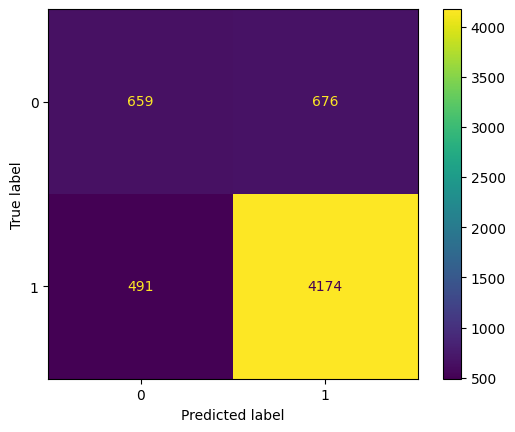

In [199]:
rf_model_smote = RandomForestClassifier(
    n_estimators=70,
    max_depth=5,
    min_samples_leaf=4,
    min_samples_split=3,
    random_state=1,
)
rf_model_smote.fit(X_train, y_train)
y_pred_rf_smote = rf_model_smote.predict(X_test)
y_pred_rf_smote_train = rf_model_smote.predict(X_train)

res(y_pred_rf_smote, y_pred_rf_smote_train)

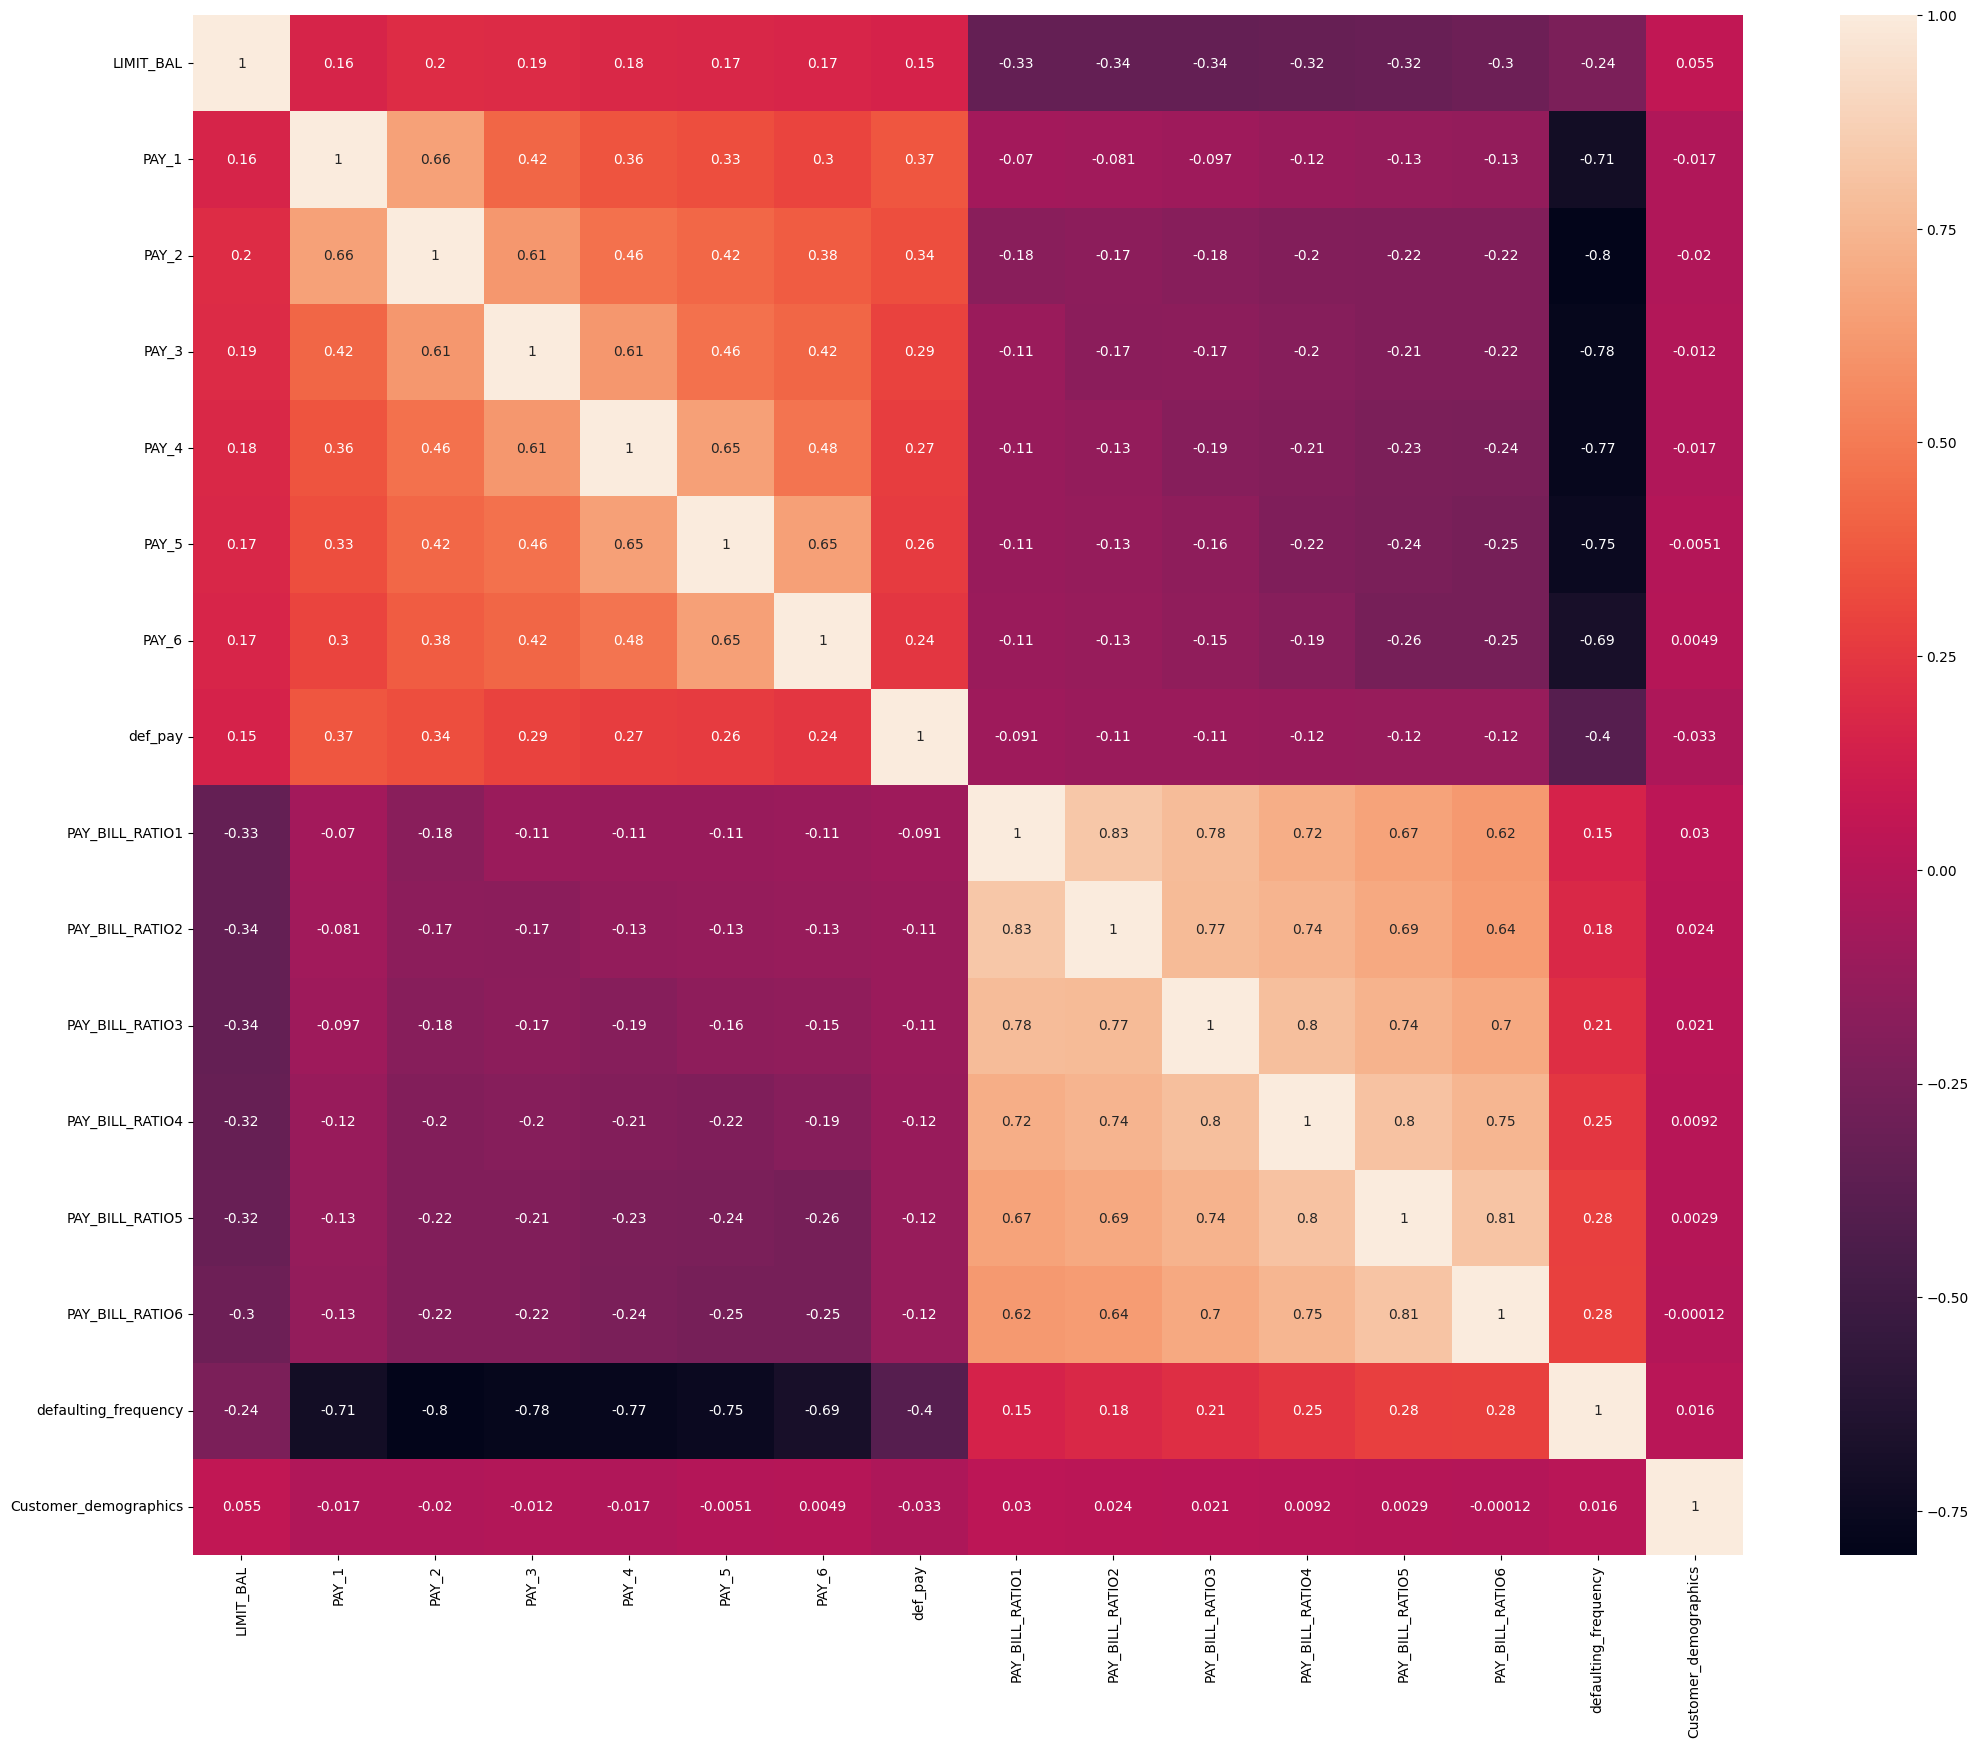

In [200]:
# Checking correlation
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(), annot=True)
plt.show()